<a href="https://colab.research.google.com/github/YBenPan/oil-forecast/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [240]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import linear_model

In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
%matplotlib inline

In [242]:
import warnings
warnings.filterwarnings("ignore", message = "No frequency information was") 

In [243]:
# Import CSV to dataframe
url = "https://raw.githubusercontent.com/YBenPan/oil-forecast/main/Oil3Data.csv"
df = pd.read_csv(url, sep = ",", index_col = 'Date', parse_dates = True)
df = df.dropna(axis = 0)

In [244]:
# Drop first 1000 data points since they cause outliers
df = df[1000:]
df

,Stock,Stock_change,Price,Price_change,Days_of_Supply,DoS_change
Date,,,,,,
2009-03-13,1023756,0.002989,45.68,0.055941,23.7,0.008511
2009-03-20,1026592,0.002770,49.46,0.082750,23.8,0.004219
2009-03-27,1033007,0.006249,53.45,0.080671,24.1,0.012605
2009-04-03,1035682,0.002590,50.32,-0.058559,24.1,0.000000
2009-04-10,1043847,0.007884,50.46,0.002782,24.6,0.020747
...,...,...,...,...,...,...
2020-10-23,1391224,-0.002780,40.56,0.001481,36.6,0.013850
2020-10-30,1376547,-0.010550,37.50,-0.075444,36.2,-0.010929
2020-11-06,1365069,-0.008338,37.91,0.010933,36.6,0.011050


Build ARIMA model: 

<ipython-input-245-bad88a45fb4c>:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  additive_decomposition = seasonal_decompose(df['Stock'], model = 'additive', freq = 30)
<ipython-input-245-bad88a45fb4c>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  multiplicative_decomposition = seasonal_decompose(df['Stock'], model = 'multiplicative', freq = 30)


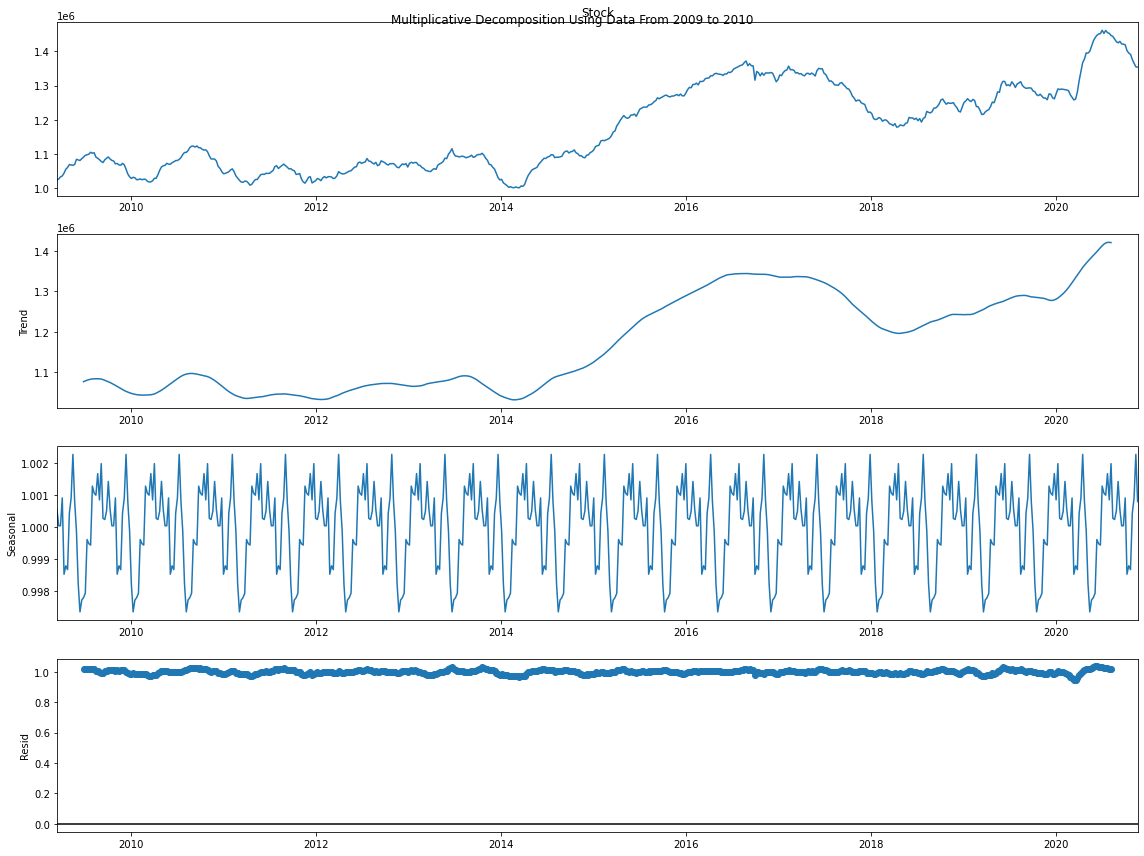

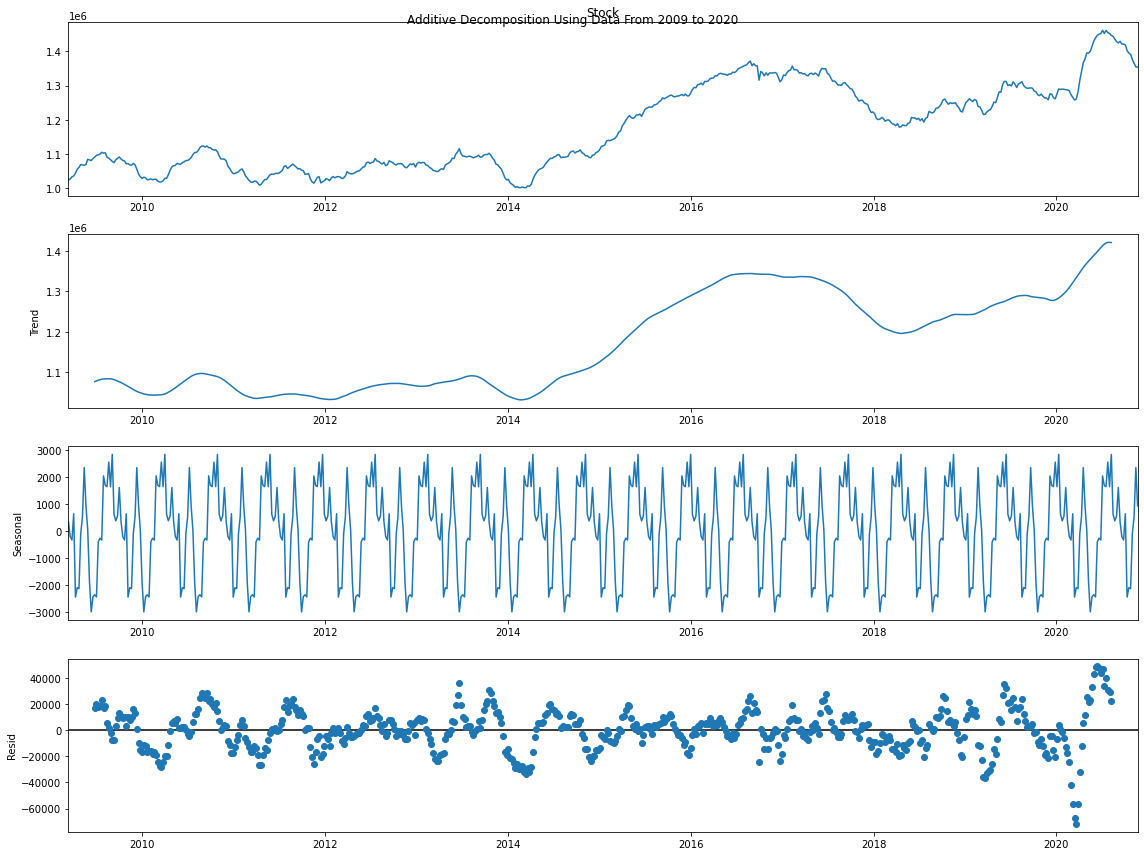

In [245]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

additive_decomposition = seasonal_decompose(df['Stock'], model = 'additive', freq = 30)
multiplicative_decomposition = seasonal_decompose(df['Stock'], model = 'multiplicative', freq = 30)

plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition Using Data From 2009 to 2010')
additive_decomposition.plot().suptitle('Additive Decomposition Using Data From 2009 to 2020')
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

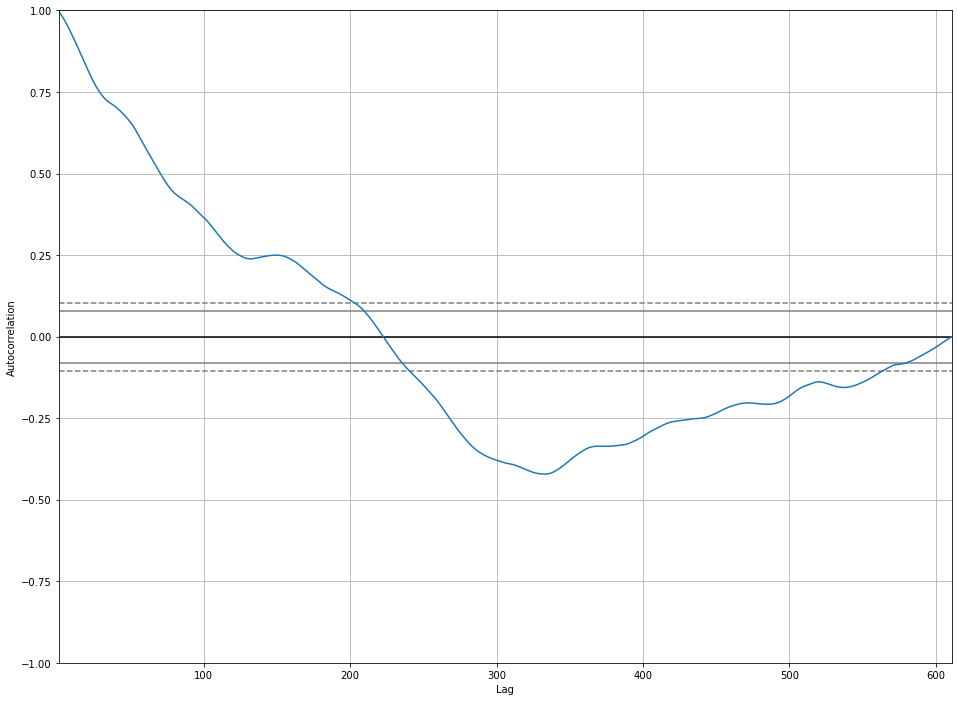

In [246]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Stock'])

In [247]:
# ARIMA Test Run
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Stock'], order = (1, 1, 2), freq = 'W-FRI')
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Stock   No. Observations:                  611
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6266.457
Date:                Mon, 14 Jun 2021   AIC                          12540.914
Time:                        22:24:56   BIC                          12558.568
Sample:                    03-13-2009   HQIC                         12547.781
                         - 11-20-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8496      0.085     10.006      0.000       0.683       1.016
ma.L1         -0.8399      0.085     -9.868      0.000      -1.007      -0.673
ma.L2          0.0048      0.007      0.702      0.4

<AxesSubplot:xlabel='Date'>

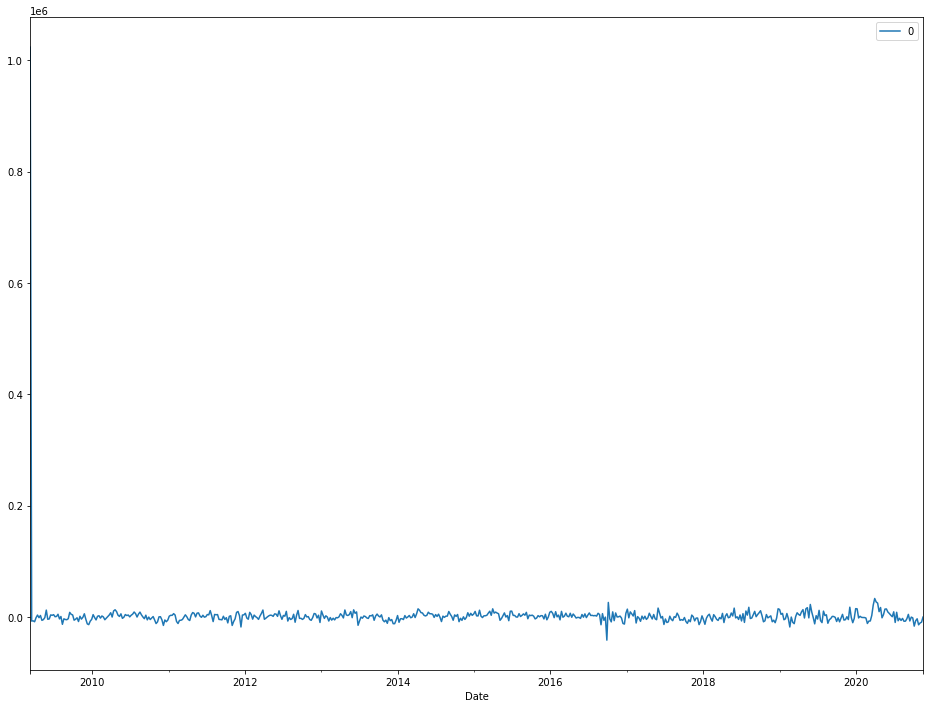

In [248]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

Model Validation: 

In [249]:
# Split into training and testing sets
dflen = len(df)
testlen = round(dflen / 5)
trainlen = dflen - testlen
train = df[0:trainlen]
test = df[trainlen: dflen]

In [250]:
# model = ARIMA(df['Stock'], order = (1, 2, 2), freq = 'W-FRI')
# model_fit = model.fit()
# output = model_fit.forecast()

In [251]:
# Apply ARIMA to the testing set
# Predict stock values

def build(train, test):
    history = train
    predictions = pd.DataFrame()
    for i in range(len(test)):
        # ARIMA
        model = ARIMA(history['Stock'], order = (1, 1, 2), freq = 'W-FRI')
        model_fit = model.fit()
        output = model_fit.forecast()
        
        # Add predicted value to the dataframe
        predicted = output[0]
        added_obj = test.iloc[i]
        predicted_series = pd.Series([predicted])
        added_obj = added_obj.append(predicted_series) 
        added_obj.index = ['Stock', 'Stock_change', 'Price', 'Price_change', 'Days of Supply', 'DoS_change', 'Predicted_Stock']
        added_obj = added_obj.rename(i)
        predictions = predictions.append(added_obj)
        history = history.append(test.iloc[i])
    return predictions

In [252]:
res = build(train, test)
res = res[['Stock', 'Stock_change', 'Predicted_Stock', 'Price', 'Price_change', 'Days of Supply', 'DoS_change']]

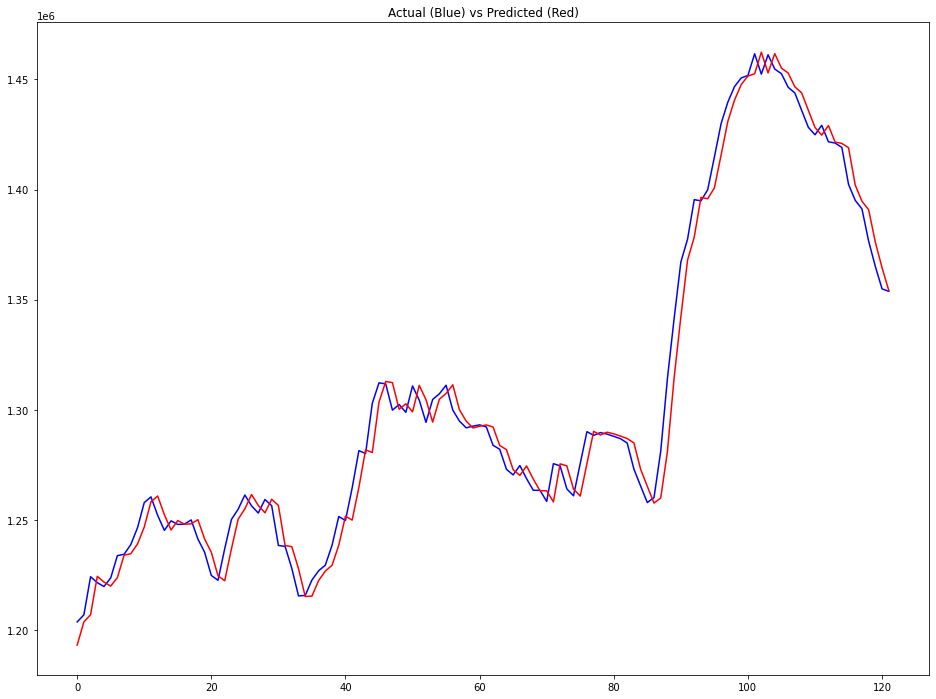

In [253]:
pre1 = res['Stock']
pre2 = res['Predicted_Stock']
pre3 = res.index
plt.title("Actual (Blue) vs Predicted (Red)")
plt.plot(pre3, pre1, label = "Actual", color = "Blue")
plt.plot(pre3, pre2, label = "Predicted", color = "Red")

In [254]:
print("Root Mean Squared Error:", math.sqrt(metrics.mean_squared_error(res['Predicted_Stock'], res['Stock'])))

Root Mean Squared Error: 9457.656483761724


In [255]:
x_train = df.loc[:, 'Stock'].values
y_train = df.loc[:, 'Price'].values
x_test = res.loc[:, 'Predicted_Stock'].values
y_test = res.loc[:, 'Price'].values

Polynomial Regression model

In [256]:
regressor = np.poly1d(np.polyfit(x_train, y_train, 3))
# print(regressor.coef_)
# print(regressor.intercept_)

Text(0, 0.5, 'Price')

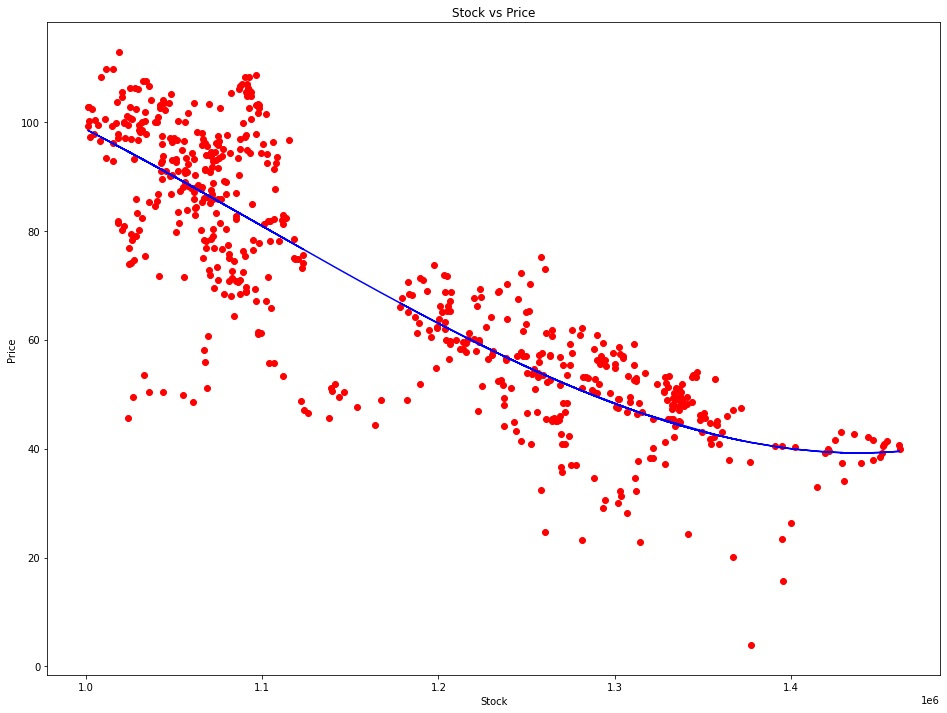

In [257]:
plt.scatter(x_train, y_train, color = "red")
plt.plot(x_train, regressor(x_train), color = "blue")
plt.title("Stock vs Price")
plt.xlabel("Stock")
plt.ylabel("Price")

In [258]:
from sklearn.metrics import r2_score
print(r2_score(y_train, regressor(x_train)))

0.7362518437146535


In [259]:
predicted = regressor(x_test)
res['Predicted_Price'] = predicted

In [260]:
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, predicted))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, predicted))
print("Root Mean Squared Error:", math.sqrt(metrics.mean_squared_error(y_test, predicted)))

Mean Absolute Error: 7.01205352253562
Mean Squared Error: 97.71584355145438
Root Mean Squared Error: 9.885132449869065


<AxesSubplot:>

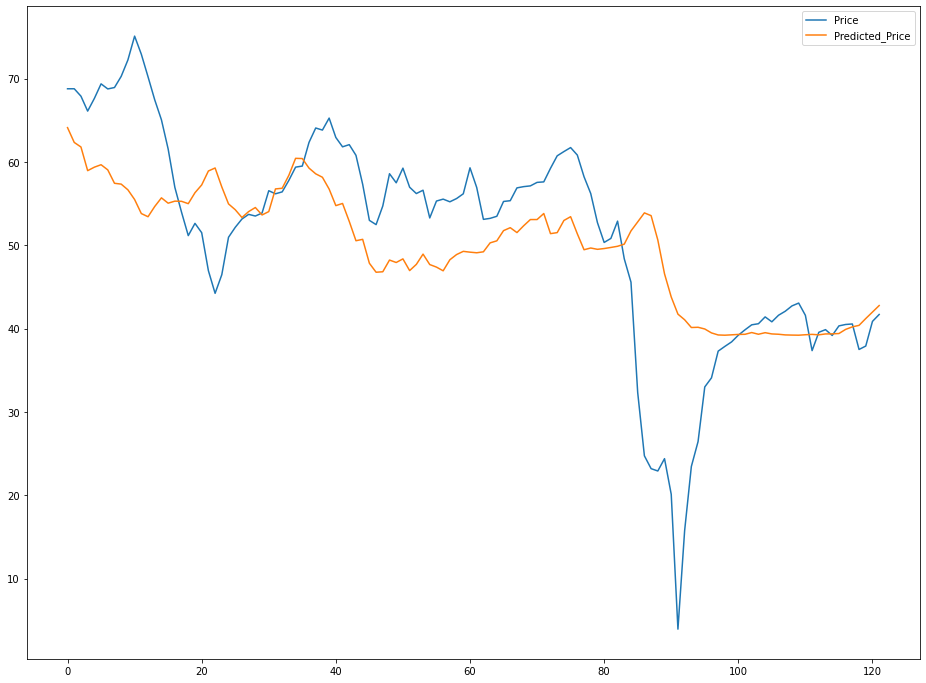

In [261]:
res.plot(y = ["Price", "Predicted_Price"])

Model Evaluation. Predicts the Price

In [262]:
model = ARIMA(df['Stock'], order = (1, 1, 2))
model_fit = model.fit()
output = model_fit.forecast()
newStock = output[0]
newPrice = regressor(newStock)
print("The next price will be:", newPrice)

The next price will be: 42.85484567464141
